# Comparison of Operational Data and Loads 
### (DTU @ IA  &  BB @ IIIB)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from lacbox.io import load_stats


# Select if operational data or loads will be plotted
plot_operational_data = False

# Constants
SEEDS = 6
BB_PATH = Path.cwd().parent / 'our_design/BB_turb_stats.csv'  # path to mean steady stats
DTU_PATH = Path.cwd().parent / 'dtu_10MW/turb/dtu_10mw_turb_stats.hdf5'  # path to mean steady stats
BB_SUBFOLDER = 'tcb'
DTU_SUBFOLDER = 'tca'
if plot_operational_data == True:
    chan_ids_we_want = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow']
else:
    chan_ids_we_want = ['TbFA', 'TbSS', 'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']


# Dict to identify which HAWC2 descriptions correspond to which channels
CHAN_DESCS = {'BldPit': 'pitch1 angle',
              'RotSpd': 'rotor speed',
              'Thrust': 'aero rotor thrust',
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# what channels we want to plot
chan_ids = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow', 'TbFA', 'TbSS',
            'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

chan_labels = [
    'Pitch angle [deg]',
    'Rotor speed [rad/s]',
    'Thrust [kN]',
    'Generator torque [Nm]',
    'Electrical power [W]',
    'Tower-base FA [kNm]',
    'Tower-base SS [kNm]',
    'Yaw-bearing tilt [kNm]',
    'Yaw-bearing roll [kNm]',
    'Shaft torsion [kNm]',
    'OoP root moment [kNm]',
    'IP root moment [kNm]'    
]

In [ ]:
def extract_and_order_statistics(wsps, chan_df, seeds):
    """
    Extract and order:
     - wsp, max, mean, min for the points
     - wsp, mean_max, mean_mean, mean_min for the mean lines
    """

    # extract hawc2 wind and channel to plot from the HAWC2 stats
    val_wsp, val_max, val_mean, val_min = chan_df['wsp'], chan_df['max'], chan_df['mean'], chan_df['min']
    val_wsp, val_max, val_mean, val_min = np.array(val_wsp), np.array(val_max), np.array(val_mean), np.array(val_min)
    i_val = np.argsort(val_wsp)

    # Get mean of max/mean/min
    mean_max = np.average(val_max[i_val].reshape(-1, seeds), axis=1)
    mean_mean = np.average(val_mean[i_val].reshape(-1, seeds), axis=1)
    mean_min = np.average(val_min[i_val].reshape(-1, seeds), axis=1)

    points = {
        'wsp': val_wsp[i_val],
        'max': val_max[i_val],
        'mean': val_mean[i_val],
        'min': val_min[i_val]
    }

    lines = {
        'wsp': wsps,
        'max': mean_max,
        'mean': mean_mean,
        'min': mean_min
    }

    return points, lines

# All together

In [ ]:
# load the data from the stats file
df_BB, wsps_BB = load_stats(BB_PATH, subfolder=BB_SUBFOLDER, statstype='turb')
df_DTU, wsps_DTU = load_stats(DTU_PATH, subfolder=DTU_SUBFOLDER, statstype='turb')


# initialize the figure and axes
fig, axs = plt.subplots(4, 3, figsize=(12, 8), clear=True)

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):
    
    # isolate the channel data and get statistics
    chan_df_BB = df_BB.filter_channel(chan_id, CHAN_DESCS)
    chan_df_DTU = df_DTU.filter_channel(chan_id, CHAN_DESCS)

    # extract and order statistics
    points_BB, lines_BB = extract_and_order_statistics(wsps_BB, chan_df_BB, SEEDS)    
    points_DTU, lines_DTU = extract_and_order_statistics(wsps_DTU, chan_df_DTU, SEEDS)

    # plot the results
    ax = axs.flatten()[iplot]
    ax.plot(points_BB['wsp'], points_BB['max'], '.', color='tab:blue', alpha=0.2, markersize=5)
    ax.plot(points_BB['wsp'], points_BB['mean'], '.', color='tab:blue', alpha=0.2, markersize=5)
    ax.plot(points_BB['wsp'], points_BB['min'], '.', color='tab:blue', alpha=0.2, markersize=5)
    ax.plot(lines_BB['wsp'], lines_BB['max'], '-', color='tab:blue', label='HAWC2 max')
    ax.plot(lines_BB['wsp'], lines_BB['mean'], '-', color='tab:blue', label='HAWC2 mean')
    ax.plot(lines_BB['wsp'], lines_BB['min'], '-', color='tab:blue', label='HAWC2 min')

    ax.plot(points_DTU['wsp'], points_DTU['max'], '.', color='tab:orange', alpha=0.2, markersize=5)
    ax.plot(points_DTU['wsp'], points_DTU['mean'], '.', color='tab:orange', alpha=0.2, markersize=5)
    ax.plot(points_DTU['wsp'], points_DTU['min'], '.', color='tab:orange', alpha=0.2, markersize=5)
    ax.plot(lines_DTU['wsp'], lines_DTU['max'], '-', color='tab:orange', label='DTU max')
    ax.plot(lines_DTU['wsp'], lines_DTU['mean'], '-', color='tab:orange', label='DTU mean')
    ax.plot(lines_DTU['wsp'], lines_DTU['min'], '-', color='tab:orange', label='DTU min')

    ax.grid('on')
    ax.set(xlabel='Wind speed [m/s]' if iplot > 8 else None,
           ylabel=f'{chan_id} [{chan_df_BB.units.iloc[0]}]', xlim=[4, 25])

axs[1, 1].legend()
fig.tight_layout()

plt.show()

# Seperate (Maybe add a MAX dashed line)

In [4]:
import matplotlib
import scienceplots

# matplotlib.rcParams.update(matplotlib.rcParamsDefault) # TO RESET  PLOTS
plt.style.use(['science'])

# Set global font properties
plt.rcParams['legend.frameon'] = True  # Enable the legend frame
plt.rcParams['legend.fancybox'] = False  # No fancybox, just a regular box
plt.rcParams['legend.edgecolor'] = 'black'  # Black edge color
plt.rcParams['legend.framealpha'] = 1  # No transparency
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'normal'

In [ ]:
# load the data from the stats file
df_BB, wsps_BB = load_stats(BB_PATH, subfolder=BB_SUBFOLDER, statstype='turb')
df_DTU, wsps_DTU = load_stats(DTU_PATH, subfolder=DTU_SUBFOLDER, statstype='turb')

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):

    # Skip unwanted channels
    if chan_id not in chan_ids_we_want:
        continue
    
    # isolate the channel data and get statistics
    chan_df_BB = df_BB.filter_channel(chan_id, CHAN_DESCS)
    chan_df_DTU = df_DTU.filter_channel(chan_id, CHAN_DESCS)

    # extract and order statistics
    points_BB, lines_BB = extract_and_order_statistics(wsps_BB, chan_df_BB, SEEDS)    
    points_DTU, lines_DTU = extract_and_order_statistics(wsps_DTU, chan_df_DTU, SEEDS)

    # Initialize
    plt.figure(figsize=(5, 3))

    # Plot BB
    plt.plot(points_BB['wsp'], points_BB['max'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(points_BB['wsp'], points_BB['mean'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(points_BB['wsp'], points_BB['min'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(lines_BB['wsp'], lines_BB['max'], '-', color='tab:blue', label='BB max')
    plt.plot(lines_BB['wsp'], lines_BB['mean'], '--', color='tab:blue', label='BB mean')
    plt.plot(lines_BB['wsp'], lines_BB['min'], '-', color='tab:blue', label='BB min')

    # Plot DTU
    plt.plot(points_DTU['wsp'], points_DTU['max'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(points_DTU['wsp'], points_DTU['mean'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(points_DTU['wsp'], points_DTU['min'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(lines_DTU['wsp'], lines_DTU['max'], '-', color='tab:orange', label='DTU max')
    plt.plot(lines_DTU['wsp'], lines_DTU['mean'], '--', color='tab:orange', label='DTU mean')
    plt.plot(lines_DTU['wsp'], lines_DTU['min'], '-', color='tab:orange', label='DTU min')

    # Add legend to only 1 from each group
    if (chan_id == 'ElPow') or (chan_id == 'ShftTrs'):
        plt.legend(loc='best', fontsize=8, ncol=2)

    # Formatting the plot
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel(chan_labels[iplot])
    plt.xlim([4, 25])
    plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='major')
    plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
    plt.savefig(f'Plots/{chan_id}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

# Short term DELs

In [5]:
def extract_and_DEL(wsps, chan_df, seeds, m):
    """
    Extract and order DEL values (del4, del4, del5, del8, del10, del12) from chan_df.
    
    Parameters:
        wsps (array-like): Wind speed values for each simulation.
        chan_df (DataFrame): Dataframe with DEL columns for each wind speed.
        seeds (int): Number of seeds used for averaging.
        m (int): [3, 4, 5, 8, 10, 12]
        
    Returns:
        points (dict): Ordered DEL values (mean of del4, del4, etc.) for each wind speed.
        lines (dict): Mean DEL values over seeds for each wind speed.
    """
    if m not in [3, 4, 5, 8, 10, 12]:
        raise ValueError("Wrong m value given!")
    else:
        del_col = f'del{m}'
    
    # Extract wind speed data and DEL columns
    val_wsp = np.array(chan_df['wsp'])
    
    # Sort indices based on wind speed
    i_val = np.argsort(val_wsp)
    
    # Initialize dictionaries to store ordered DEL values
    points = {'wsp': val_wsp[i_val]}
    lines = {'wsp': wsps}

    # Extract and order the DEL data for this column
    
    del_data = np.array(chan_df[del_col])[i_val]
    
    # Using Miner's Rule
    del_values = del_data.reshape(-1, seeds)
    combined_del = (np.sum(del_values ** m , axis=1)  / seeds) ** (1 / m) # m is the WOhler Exponent
   
    # Store the mean values in the dictionaries
    points['del'] = del_data
    lines['del'] = combined_del

    return points, lines


# NOT SURE ABOUT "m" values

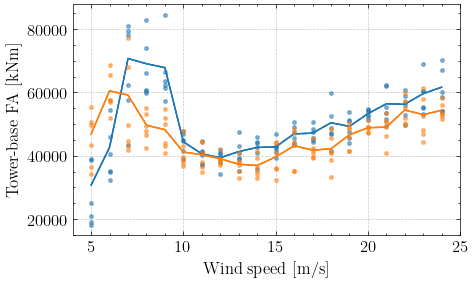

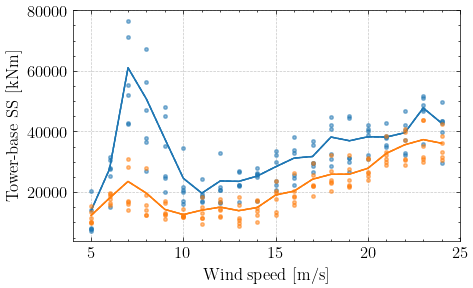

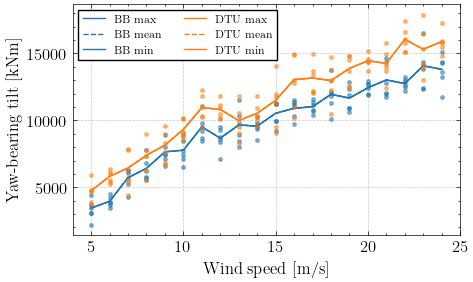

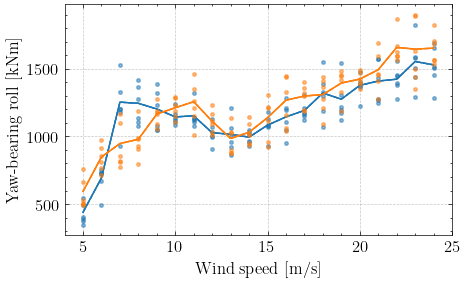

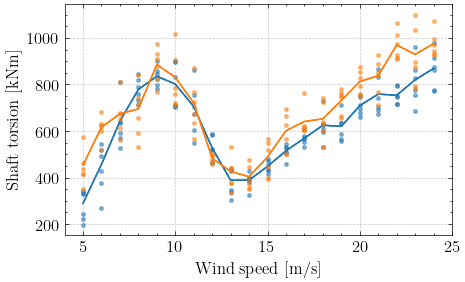

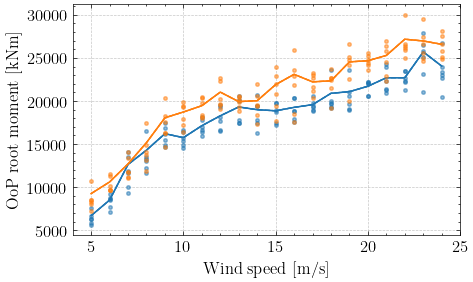

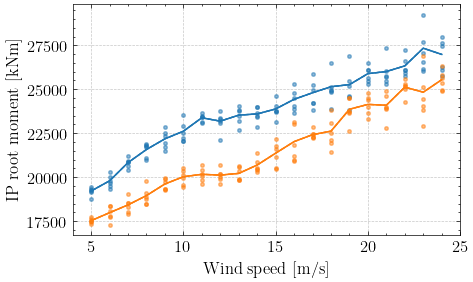

In [10]:
# What 
chan_ids_we_want = ['TbFA', 'TbSS', 'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']
m_list = [4, 4, 3, 3, 3, 10, 10]
j = 0

# load the data from the stats file
df_BB, wsps_BB = load_stats(BB_PATH, subfolder=BB_SUBFOLDER, statstype='turb')
df_DTU, wsps_DTU = load_stats(DTU_PATH, subfolder=DTU_SUBFOLDER, statstype='turb')

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):

    # Skip unwanted channels
    if chan_id not in chan_ids_we_want:
        continue
    else:
        m = m_list[j]
        j = j + 1
    
    # isolate the channel data and get statistics
    chan_df_BB = df_BB.filter_channel(chan_id, CHAN_DESCS)
    chan_df_DTU = df_DTU.filter_channel(chan_id, CHAN_DESCS)

    # extract and order statistics
    points_BB, lines_BB = extract_and_DEL(wsps_BB, chan_df_BB, SEEDS, m)
    points_DTU, lines_DTU = extract_and_DEL(wsps_DTU, chan_df_DTU, SEEDS, m)

    # Initialize
    plt.figure(figsize=(5, 3))

    # Plot BB
    plt.plot(points_BB['wsp'], points_BB['del'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(points_BB['wsp'], points_BB['del'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(points_BB['wsp'], points_BB['del'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(lines_BB['wsp'], lines_BB['del'], '-', color='tab:blue', label='BB max')
    plt.plot(lines_BB['wsp'], lines_BB['del'], '--', color='tab:blue', label='BB mean')
    plt.plot(lines_BB['wsp'], lines_BB['del'], '-', color='tab:blue', label='BB min')

    # Plot DTU
    plt.plot(points_DTU['wsp'], points_DTU['del'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(points_DTU['wsp'], points_DTU['del'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(points_DTU['wsp'], points_DTU['del'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(lines_DTU['wsp'], lines_DTU['del'], '-', color='tab:orange', label='DTU max')
    plt.plot(lines_DTU['wsp'], lines_DTU['del'], '--', color='tab:orange', label='DTU mean')
    plt.plot(lines_DTU['wsp'], lines_DTU['del'], '-', color='tab:orange', label='DTU min')

    # Add legend to only 1 from each group
    if chan_id == 'YbTilt':
        plt.legend(loc='best', fontsize=8, ncol=2)

    # Formatting the plot
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel(chan_labels[iplot])
    plt.xlim([4, 25])
    plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='major')
    plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
    plt.savefig(f'Plots/del_{chan_id}.pdf', dpi=300, bbox_inches='tight')

    plt.show()